In [1]:
import sys, os, time, shutil, random
from pathlib import Path
# if '_cwd' not in locals():
#     _cwd = os.getcwd()
#     os.chdir(Path(_cwd)/'..')

import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from tabulate import tabulate
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm
from copy import deepcopy

from omnibelt import load_yaml, save_yaml


In [2]:
root = Path(r'assets\old\data\classic')


In [3]:
nodes = load_yaml(root / 'nodes.yaml')
edges = load_yaml(root / 'edges.yaml')
pos = load_yaml(root / 'pos.yaml')
len(nodes), len(edges), len(pos)

(75, 2, 122)

In [7]:
graph = deepcopy(nodes)
bgs = {}
len(graph)

119

In [8]:
for ID, es in edges['army'].items():
    node = graph[ID]
    if 'edges' not in node:
        node['edges'] = {'army': es.copy()}


In [9]:
for ID, es in edges['fleet'].items():
    node = graph.get(ID)
    coast = None
    if node is None:
        base, coast = ID.split('-')
        node = graph[base]
    if 'edges' not in node:
        node['edges'] = {}
    if coast is None:
        node['edges']['fleet'] = []
        ne = node['edges']['fleet']
    elif 'fleet' in node['edges']:
        node['edges']['fleet'][coast] = []
        ne = node['edges']['fleet'][coast]
    else:
        node['edges']['fleet'] = {coast:[]}
        ne = node['edges']['fleet'][coast]
    ne.extend(es)

In [10]:
for ID, pois in pos.items():
    node = graph.get(ID)
    coast = None
    if node is None:
        base, coast = ID.split('-')
        if base == 'neutral':
            bgs[coast] = deepcopy(pois['fill'])
            continue
        node = graph[base]
    
    if 'locs' not in node:
        node['locs'] = {}
    locs = node['locs']
    if coast is None:
        locs['unit'] = [pois['base'].copy()]
        if 'center' in pois:
            locs['sc'] = [pois['center'].copy()]
        if 'retreat' in pois:
            locs['retreat'] = [pois['retreat'].copy()]
        if 'text' in pois:
            locs['label'] = [pois['text'].copy()]
    elif coast == 'c':
        locs['coast-unit'] = [pois['base'].copy()]
        if 'retreat' in pois:
            locs['coast-retreat'] = [pois['retreat'].copy()]
    else:
        if 'coast-unit' not in locs:
            locs['coast-unit'] = {}
        locs['coast-unit'][coast] = [pois['base'].copy()]
        if 'retreat' in pois:
            if 'coast-retreat' not in locs:
                locs['coast-retreat'] = {}
            locs['coast-retreat'][coast] = [pois['retreat'].copy()]
        if 'text' in pois:
            if 'coast-label' not in locs:
                locs['coast-label'] = {}
            locs['coast-label'][coast] = [pois['text'].copy()]
            
    if 'fill' in pois:
        node['region-coords'] = deepcopy(pois['fill'])

In [15]:
graph['aby']

{'name': 'Abyssinia',
 'pos': [273.21772039180746, 1024.9229741763133],
 'type': 'land',
 'edges': {'army': ['som', 'eri', 'sud']},
 'locs': {'unit': [[257.55388598459746, 1005.0914409714705]],
  'retreat': [[242.63594845392134, 979.7309471693211]],
  'label': [[271.41451469278695, 1026.7261798753336]]},
 'region-coords': [[257.55388598459746, 1021.5011722552143]]}

In [16]:
# save_yaml(graph, root / 'graph.yaml')

In [18]:
# save_yaml(bgs, root / 'bgs.yaml')

In [19]:

from sklearn.neighbors import NearestNeighbors
import networkx as nx
import cv2
import random
import ctypes
from scipy.signal import convolve2d, correlate2d
import ipywidgets as widgets
from IPython.display import display, clear_output
from collections import Counter
import io

from omnibelt import load_yaml, save_yaml, multi_index

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.segmentation import *
from skimage.segmentation import watershed, expand_labels
from skimage.morphology import closing, square, dilation
from PIL import Image

In [26]:
def showx(im, cover=None):
    plt.figure(figsize=(8,6))
    try:
        plt.imshow(im.astype(int))
        if cover is not None:
            plt.imshow(cover%1000, alpha=0., zorder=10)
    except ValueError:
        plt.imshow(im)
    
    plt.axis('off')
    plt.subplots_adjust(0,0,1,1)

def highlight(rgb, mask, opacity=0.2):
    alpha = np.zeros_like(mask).astype(np.uint8)
    
    img = rgb.astype(np.uint8)
    
    alpha[mask!=0] = 255
    alpha[mask==0] = int(255*opacity)
    
    H,W,C = img.shape
    
    if C == 4:
        img[...,-1] = alpha
    else:
        img = np.concatenate([img, alpha.reshape(H,W,1)],-1)
    return showx(img)
    
def show(im):
    return Image.fromarray(im)

def show_region(base, region, rad=500):
#     region = regions[ind]
    y1, x1, y2, x2 = region.bbox
    x, y = x1, y1
    h = y2 - y1
    w = x2 - x1
    cy, cx = region.centroid

    showx(base)

    r = rad
    if h < r:
        h = r
        y = cy - r / 2
    if w < r:
        w = r
        x = cx - r / 2

    plt.xlim(x, x + w)
    plt.ylim(y + h, y)

In [45]:
root = Path('assets/classic')

# mono_path = root / 'wd_mono.png'
color_path = root / 'base.png'

<IPython.core.display.Javascript object>


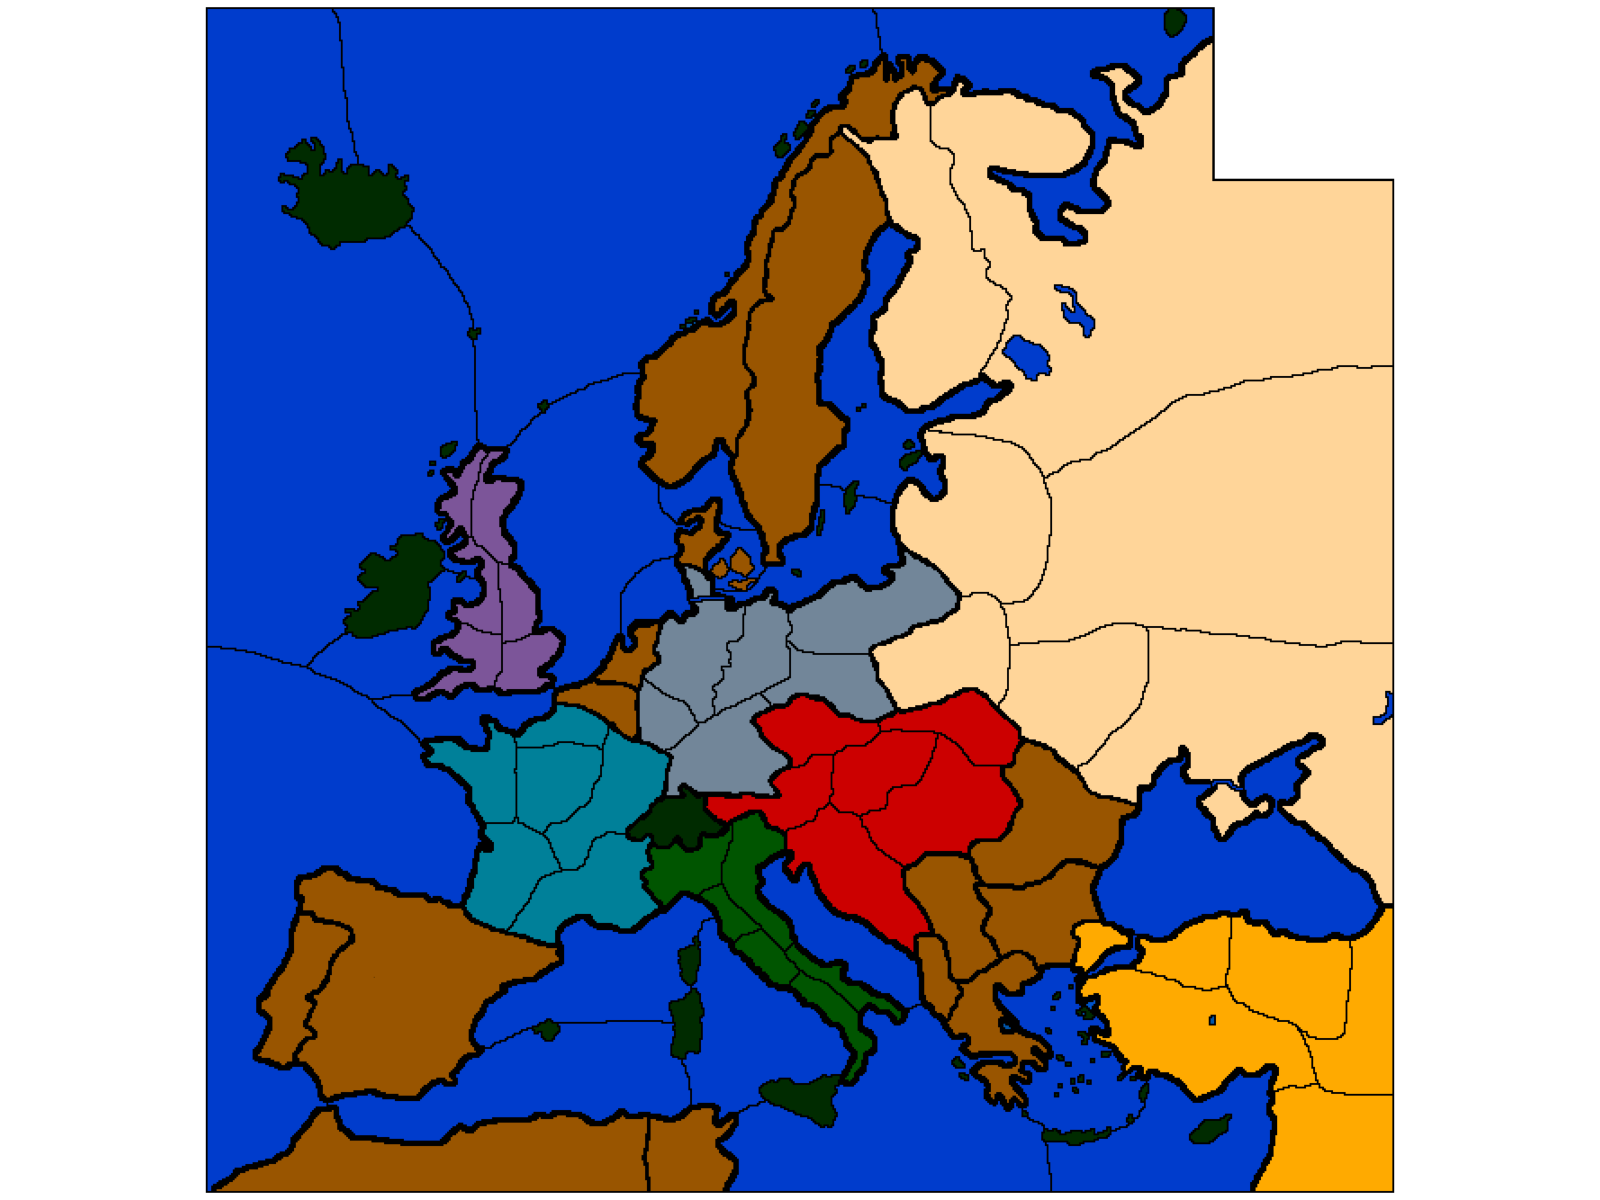

In [46]:
im = Image.open(color_path).convert('RGBA')
im = np.asarray(im)
# show(im)
showx(im[...,:3])
# im.shape

In [47]:
border = im[...,:3].astype(int).sum(-1)==0
border.shape, border.sum()

((2001, 1986), 331519)

<IPython.core.display.Javascript object>


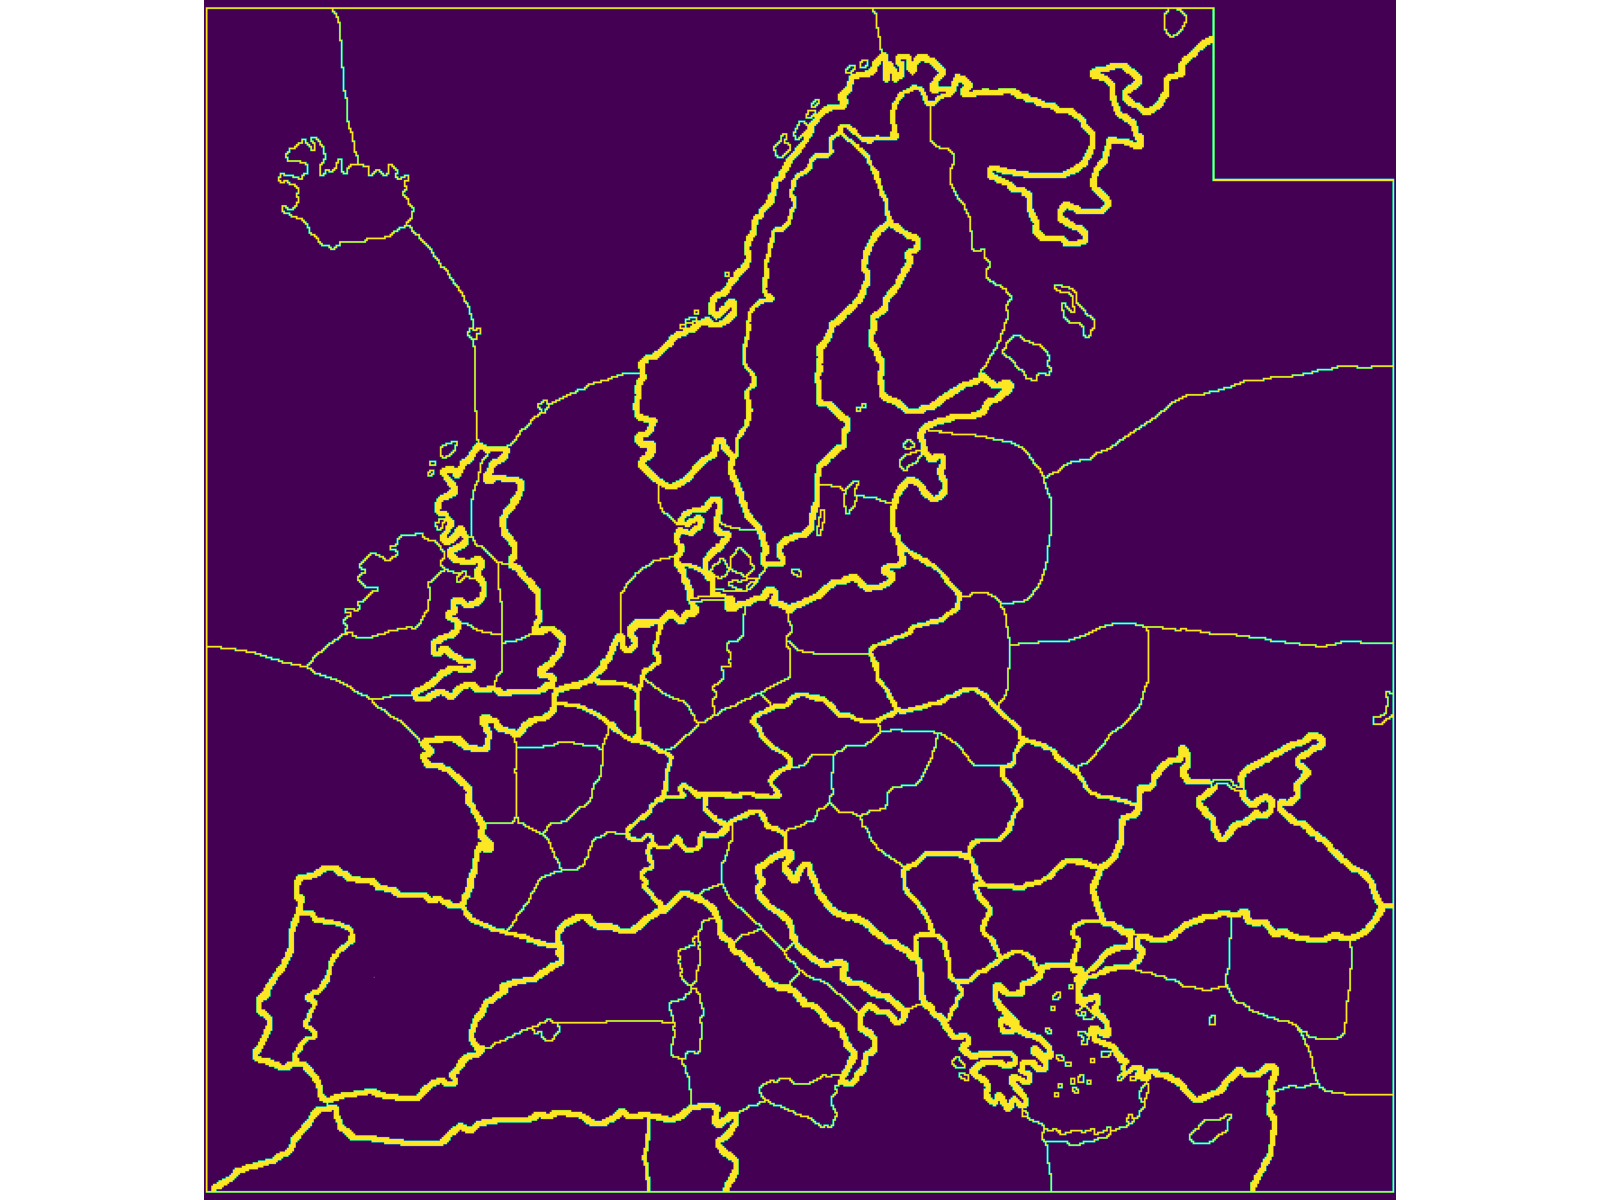

In [48]:
showx(border)

<IPython.core.display.Javascript object>


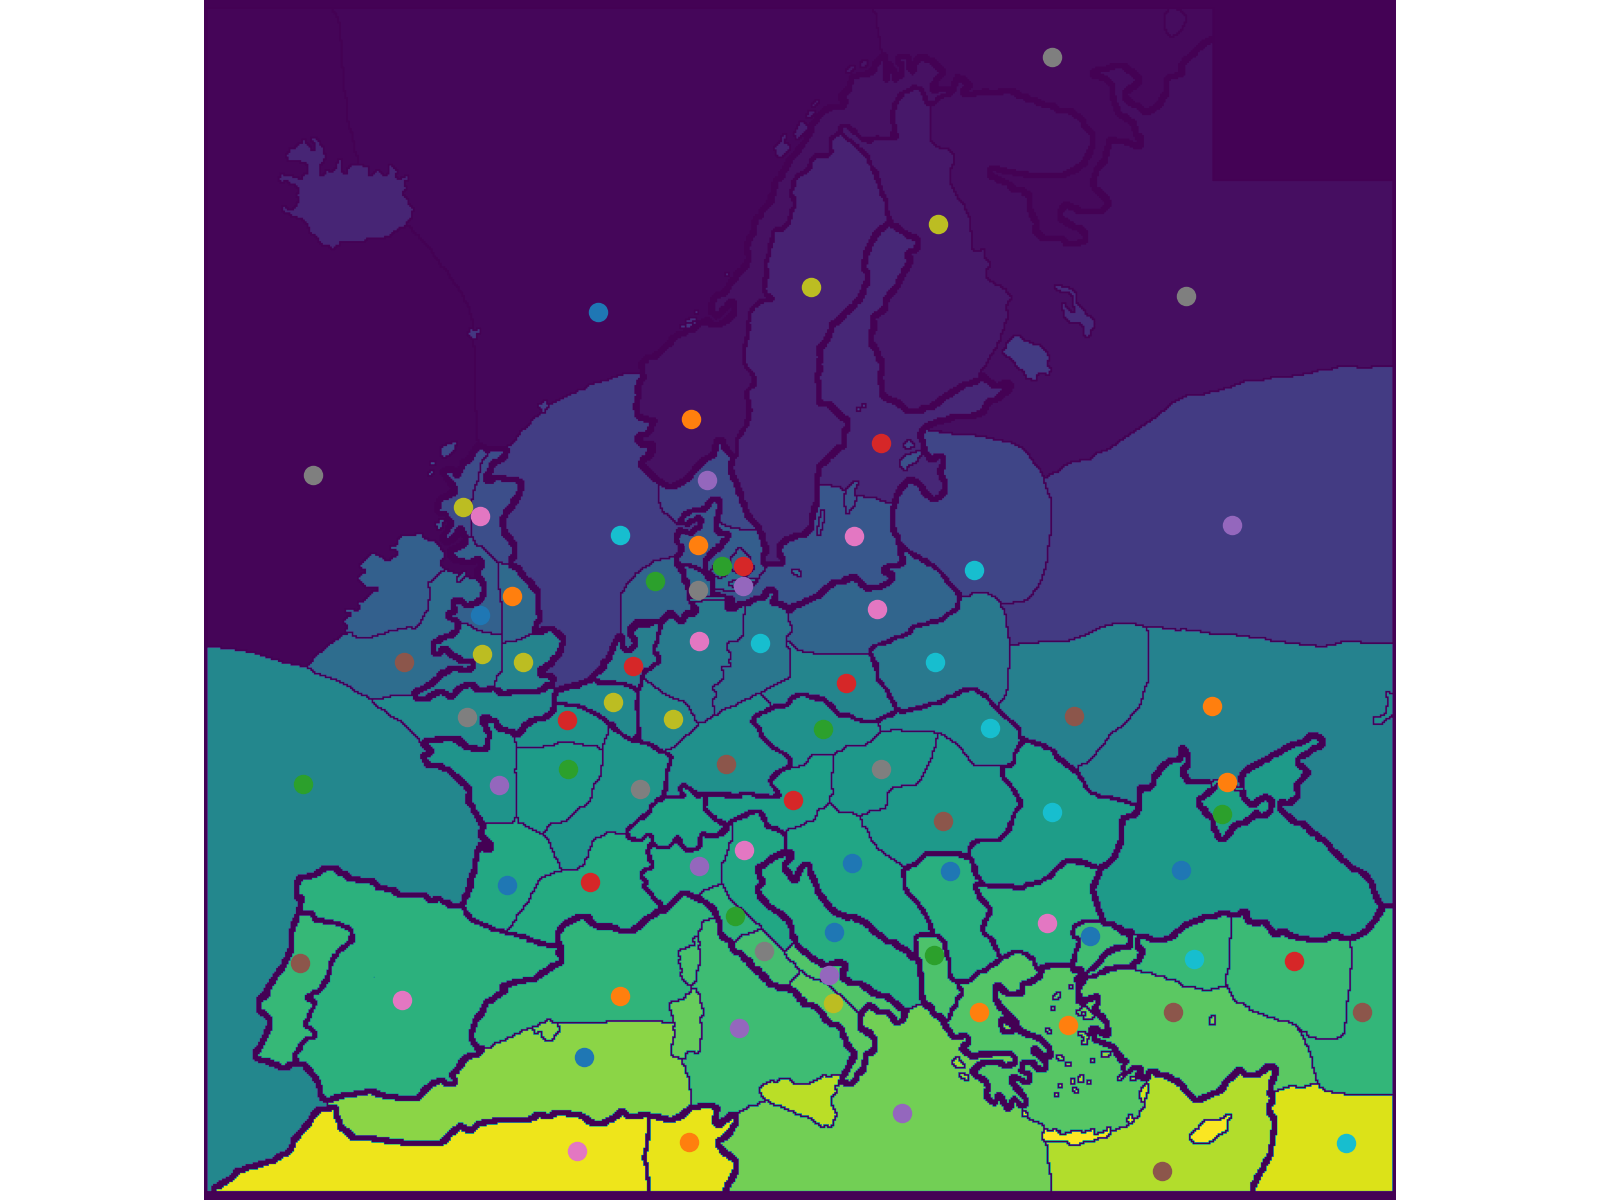

In [66]:
tiles = label(np.logical_not(border))
showx(tiles)

In [54]:
graph = load_yaml(root / 'graph.yaml')
len(graph)

75

In [67]:
ids = {}
for name, node in graph.items():
    if name not in ids:
        ids[name] = []
    for x,y in node.get('region-coords', []):
        plt.scatter(x,y,marker='o')
        ids[name].append(tiles[int(y), int(x)])
len(ids)

75

In [74]:
regIDs = {}
regs = tiles.copy()*0
for ID, (name, tidx) in tqdm(enumerate(ids.items()), total=len(ids)):
    for idx in tidx:
        regs[tiles==idx] = ID+1
    regIDs[name] = ID+1

  0%|          | 0/75 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


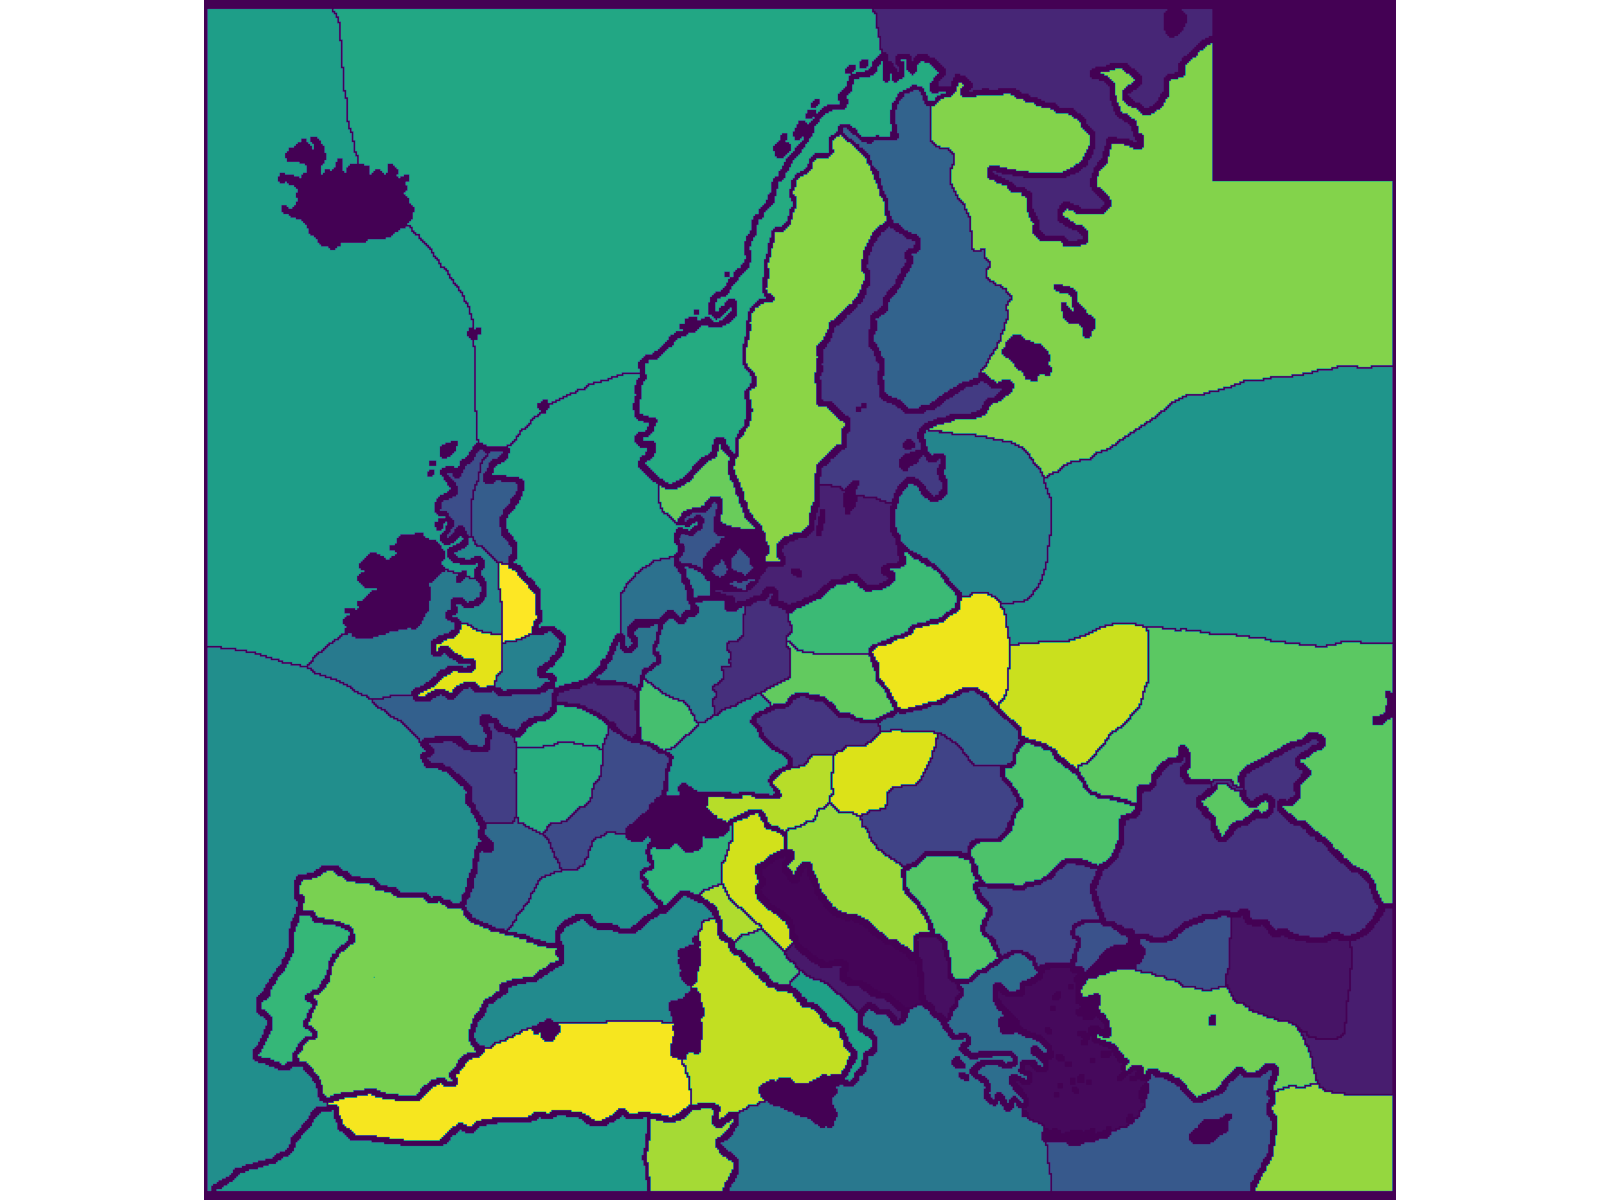

In [75]:
showx(regs)

In [76]:
# Image.fromarray(tiles.astype(np.int16)).save(root / "tiles.png")
# Image.fromarray(regs.astype(np.int16)).save(root / "regions.png")

In [80]:
for name, node in graph.items():
    if name in ids:
        node['tiles'] = list(map(int,ids[name]))
    if name in regIDs:
        node['ID'] = int(regIDs[name])

In [81]:
# save_yaml(graph, root / 'graph.yaml')

In [ ]:

def upperify(name):
    if '-' in name:
        base, coast = name.split('-')
        return '-'.join([base.upper(), coast])
    return name.upper()


In [4]:
root = Path('assets/classic')

In [5]:
graph = load_yaml(root / 'graph.yaml')
len(graph)

75

In [7]:
new = {}

for name, node in graph.items():
    new[upperify(name)] = node
    for et, es in node['edges'].items():
        if isinstance(es, list):
            node['edges'][et] = list(map(upperify, es))
        else:
            node['edges'][et] = {c:list(map(upperify, ces)) for c, ces in es.items()}
len(new)

75

In [9]:
# save_yaml(new, root / 'graph.yaml')

In [10]:
players = load_yaml(root / 'players.yaml')
len(players)

7

In [12]:
players['England']

{'name': 'England',
 'demonym': 'English',
 'territory': ['cly', 'edi', 'lvp', 'yor', 'wal', 'lon'],
 'home': ['lon', 'edi', 'lvp'],
 'capital': 'lon',
 'color': '#4477AA',
 'units': [{'type': 'fleet', 'loc': 'edi'},
  {'type': 'fleet', 'loc': 'lon'},
  {'type': 'army', 'loc': 'lvp'}]}

In [13]:
for name, info in players.items():
    info['territory'] = list(map(upperify, info['territory']))
    info['home'] = list(map(upperify, info['home']))
    info['capital'] = upperify(info['capital'])
    
    for unit in info['units']:
        unit['loc'] = upperify(unit['loc'])
    

In [14]:
players['England']

{'name': 'England',
 'demonym': 'English',
 'territory': ['CLY', 'EDI', 'LVP', 'YOR', 'WAL', 'LON'],
 'home': ['LON', 'EDI', 'LVP'],
 'capital': 'LON',
 'color': '#4477AA',
 'units': [{'type': 'fleet', 'loc': 'EDI'},
  {'type': 'fleet', 'loc': 'LON'},
  {'type': 'army', 'loc': 'LVP'}]}

In [16]:
# save_yaml(players, root / 'players.yaml')